# Data Exploration
this file is used to get an overview over the files, that are on the IMI server. Included .csv files are loaded and used to determine which probands can be used.

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import torch
import torch.nn.functional as F
import os
#from utils.plotting import flow2img, overlaySegment
#from utils.encoding import dice_coeff
#from utils.layers import warp, warpImage
#from utils.load_models import load_flownet2
#from utils.preprocessing import preprocessing_flownet

In [2]:
# files are located here
path_to_data = "/share/data_ultraschall/compressions"

In [3]:
len(os.listdir(path_to_data))

2194

In [6]:
# manually, but somewhat random selected to see the image quality
test_dir = os.path.join(path_to_data, "157")
test_dir

'/share/data_ultraschall/compressions/157'

In [7]:
# get two random images 
random_frames = np.random.choice(os.listdir(os.path.join(test_dir,"frames")), 2)
random_frames

array(['image_0189.png', 'image_0134.png'], dtype='<U14')

In [8]:
# load images and segmentations
img_1 = Image.open(os.path.join(test_dir,"frames",random_frames[0]))
img_2 = Image.open(os.path.join(test_dir,"frames",random_frames[1]))

seg_1 = Image.open(os.path.join(test_dir,"segmentations","1",random_frames[0]))
seg_2 = Image.open(os.path.join(test_dir,"segmentations","1",random_frames[1]))

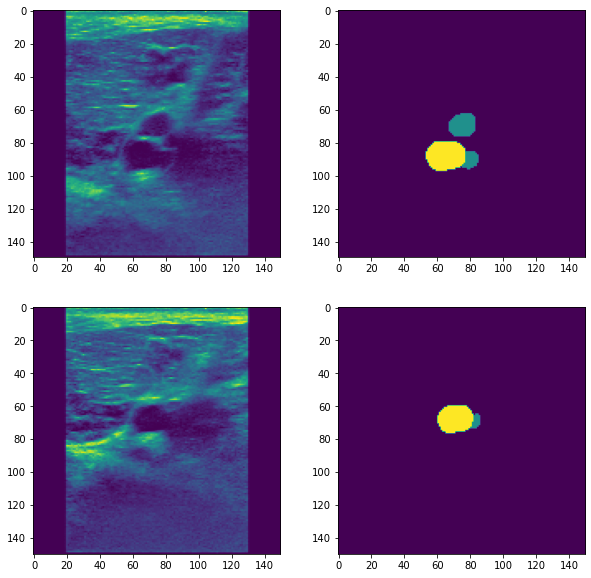

In [9]:
fig = plt.figure(figsize=(10,10))

plt.subplot(221)
plt.imshow(img_1)
plt.subplot(222)
plt.imshow(seg_1)
plt.subplot(223)
plt.imshow(img_2)
plt.subplot(224)
plt.imshow(seg_2)

In [10]:
# images need to be normalized
print(np.array(img_1).max())

# segmentations have labels of 0,1,2 and will be divided by 100
print(np.array(seg_1).max())

219
200


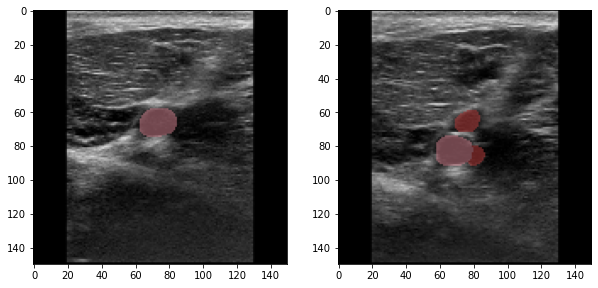

In [9]:
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(overlaySegment(torch.from_numpy(np.array(img_1))/255,torch.from_numpy(np.array(seg_1))/100))
plt.subplot(122)
plt.imshow(overlaySegment(torch.from_numpy(np.array(img_2))/255,torch.from_numpy(np.array(seg_2))/100))

In order to get the right label for the segmentation, we need to divide the seg image by 100, as the labels are read in as 0, 100, and 200. the image needs to be devided by 255 to get float numbers

# Plotting from randomly from all folders
there ar around 3000 recordings and about 250.000 images with segmentations. There will need to be a selection of images taken. Maybe 1500 or 2000 images and segmentations overall. The distribution of the three markers should be 1/3 for each scan location. For this we need an overview over the different recordings. This is included in the quality.csv and sequences.csv files in the cocoAi filder...

In [4]:
# load the quality overview
quality = pd.read_csv("~/MasterThesis/quality.csv")

# More info about the sequences
sequences = pd.read_csv("~/MasterThesis/sequences.csv")

In [5]:
quality

,ID,Vessel in Frame,LM configuration,Vein contrast/cropping error,Artery contrast,Vein boundary,Artery boundary,Gain,Depth,Artefacts,Movement,Total
0,113.0,1.0,3.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,17
1,116.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,11
2,119.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,12
3,120.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,16
4,121.0,1.0,2.0,3.0,2.0,3.0,1.0,1.0,1.0,2.0,1.0,17
...,...,...,...,...,...,...,...,...,...,...,...,...
4762,11276.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,1.0,2.0,1.0,17
4763,11277.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,14
4764,11278.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,16
4765,11280.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,12


In [6]:
sequences

,Id,Patient,Device,Leg,Anatomy,Landmark,Datatype
0,1,1,guys,RT,SFV1,LM5,healthy
1,2,1,guys,RT,SFV2,LM6,healthy
2,3,1,guys,LT,CFV / GSV + SFA / PFA,LM3,healthy
3,4,1,guys,LT,SFV1,LM5,healthy
4,5,1,guys,LT,SFV2,LM6,healthy
...,...,...,...,...,...,...,...
3862,5396,228,philips,LT,GSV / CFV + SFA / PFA,"LM1,LM3",healthy
3863,5397,224,philips,RT,POPV,LM8,healthy
3864,5682,280,philips,RT,SFV + SFA,LM6,healthy
3865,5687,282,philips,RT,SFV + SFA,LM6,healthy


In [7]:
# somewhat even
sequences['Leg'].value_counts()

RT    2149
LT    1598
Name: Leg, dtype: int64

There are some things, that need to be fulfilled in orer for the sequence to be used for training. The table below sums up all the different Columns and what needs to be fulfilled in order to use the ID for the training

| Quality Description | useable Index | Description |
|---|---|---|
|Vessel boundary| 1,2| Vessel partially cut of or fully visible during frames|
|LM configuration| 1,2| Landmarks are somewhat present for flow estimation|
|Vein contrast| 1,2 | some loss of contrast, but still visible|
|Artery contrast| 1,2 | some loss of contrast, but stil visible|
|shaprnes of Vein boundaries| 1,2 | up until poorly visible boundaries, We try to learn the overall flow|
|shaprnes of artery boundaries| 1,2 | up until poorly visible boundaries, We try to learn the overall flow|
|Overall gain| 1 | only good images are taken. Not too bright or too dark|
|artefacts| 1,2 | some aftefacts are present in the some frames|
| Movement Sequence| 1,2| Exclude "lot's" of movement for now. The other indicate some slow or fast compression of the vein|

In [8]:
# filter based on the table above
useable = quality[
    #(quality["Vessel in Frame"] <3) &
    #(quality['LM configuration'] < 4) &
    #(quality['Vein contrast/cropping error'] < 3) &
    #(quality['Artery contrast'] < 3) &
    #(quality['Vein boundary'] < 3) &
    #(quality['Artery boundary'] < 3) &
    #(quality['Gain'] == 1) &
    #(quality['Artefacts'] < 3) &
    #(quality['Movement'] < 3) &
    (quality['Total'] < 20)
]
useable.rename(columns={'ID': 'Id'}, inplace=True)
useable

/home/nicke/miniconda3/envs/flowenv/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Id,Vessel in Frame,LM configuration,Vein contrast/cropping error,Artery contrast,Vein boundary,Artery boundary,Gain,Depth,Artefacts,Movement,Total
0,113.0,1.0,3.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,17
1,116.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,11
2,119.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,12
3,120.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,16
4,121.0,1.0,2.0,3.0,2.0,3.0,1.0,1.0,1.0,2.0,1.0,17
...,...,...,...,...,...,...,...,...,...,...,...,...
4762,11276.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,1.0,2.0,1.0,17
4763,11277.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,14
4764,11278.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,16
4765,11280.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,12


In [33]:
# filter based on useable
#overview = sequences[sequences.Id.isin(useable.ID.tolist())]
overview = sequences.merge(useable, on='Id')
overview

,Id,Patient,Device,Leg,Anatomy,Landmark,Datatype,Vessel in Frame,LM configuration,Vein contrast/cropping error,Artery contrast,Vein boundary,Artery boundary,Gain,Depth,Artefacts,Movement,Total
0,1,1,guys,RT,SFV1,LM5,healthy,1.0,1.0,2.0,2.0,3.0,3.0,1.0,1.0,2.0,1.0,17
1,2,1,guys,RT,SFV2,LM6,healthy,1.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,2.0,1.0,14
2,4,1,guys,LT,SFV1,LM5,healthy,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,15
3,5,1,guys,LT,SFV2,LM6,healthy,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,11
4,9,2,guys,RT,SFV1,LM5,healthy,1.0,1.0,3.0,3.0,2.0,2.0,1.0,1.0,2.0,1.0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,5396,228,philips,LT,GSV / CFV + SFA / PFA,"LM1,LM3",healthy,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,17
1904,5397,224,philips,RT,POPV,LM8,healthy,1.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,1.0,18
1905,5682,280,philips,RT,SFV + SFA,LM6,healthy,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,16
1906,5687,282,philips,RT,SFV + SFA,LM6,healthy,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,12


In [34]:
# Check how many of the selected IDs are available as data
overview_clean = overview[overview['Id'].astype(str).isin(os.listdir(path_to_data))]
overview_clean

,Id,Patient,Device,Leg,Anatomy,Landmark,Datatype,Vessel in Frame,LM configuration,Vein contrast/cropping error,Artery contrast,Vein boundary,Artery boundary,Gain,Depth,Artefacts,Movement,Total
2,4,1,guys,LT,SFV1,LM5,healthy,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,15
4,9,2,guys,RT,SFV1,LM5,healthy,1.0,1.0,3.0,3.0,2.0,2.0,1.0,1.0,2.0,1.0,17
5,10,2,guys,RT,SFV2,LM6,healthy,1.0,1.0,3.0,3.0,3.0,3.0,1.0,1.0,2.0,1.0,19
6,12,2,guys,LT,SFV1,LM5,healthy,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,13
7,13,2,guys,LT,SFV2,LM6,healthy,1.0,2.0,2.0,2.0,3.0,3.0,1.0,1.0,2.0,1.0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,5394,228,philips,LT,CFV + SFA / PFA,LM3,healthy,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,14
1903,5396,228,philips,LT,GSV / CFV + SFA / PFA,"LM1,LM3",healthy,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,17
1905,5682,280,philips,RT,SFV + SFA,LM6,healthy,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,16
1906,5687,282,philips,RT,SFV + SFA,LM6,healthy,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,12


In [35]:
# get an overview. all seems to be fine.
print(overview_clean['Leg'].value_counts())
print(overview_clean['Device'].value_counts())
print(overview_clean['Datatype'].value_counts())

RT    561
LT    517
Name: Leg, dtype: int64
philips       499
clarius-hd    339
clarius       193
guys           52
georges         4
Name: Device, dtype: int64
healthy                636
not closing            211
invalid compression    161
background              42
sliding                 26
compression 1            5
compression 2            5
pathological             1
Name: Datatype, dtype: int64


In [36]:
# Are all IDs available as segmented data?
available_seg = []
for proband in overview_clean['Id'].values:
    proband_path = os.path.join(path_to_data,str(proband))
    if "segmentations" in os.listdir(proband_path):
        available_seg.append(proband)
len(available_seg)

473

In [37]:
# filter based on segmentation available
overview_available = overview_clean[overview_clean['Id'].isin(available_seg)]
overview_available

,Id,Patient,Device,Leg,Anatomy,Landmark,Datatype,Vessel in Frame,LM configuration,Vein contrast/cropping error,Artery contrast,Vein boundary,Artery boundary,Gain,Depth,Artefacts,Movement,Total
2,4,1,guys,LT,SFV1,LM5,healthy,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,15
4,9,2,guys,RT,SFV1,LM5,healthy,1.0,1.0,3.0,3.0,2.0,2.0,1.0,1.0,2.0,1.0,17
5,10,2,guys,RT,SFV2,LM6,healthy,1.0,1.0,3.0,3.0,3.0,3.0,1.0,1.0,2.0,1.0,19
6,12,2,guys,LT,SFV1,LM5,healthy,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,13
7,13,2,guys,LT,SFV2,LM6,healthy,1.0,2.0,2.0,2.0,3.0,3.0,1.0,1.0,2.0,1.0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,5394,228,philips,LT,CFV + SFA / PFA,LM3,healthy,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,14
1903,5396,228,philips,LT,GSV / CFV + SFA / PFA,"LM1,LM3",healthy,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,17
1905,5682,280,philips,RT,SFV + SFA,LM6,healthy,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,16
1906,5687,282,philips,RT,SFV + SFA,LM6,healthy,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,12


In [20]:
# sest random seed so we can come back and examine the data
np.random.seed(42)

In [21]:
# choose 4 to visualize
random_selected_ids = np.random.choice(overview_available['Id'].values, size=6)
random_selected_ids

array([ 516, 3507, 2468, 1605,  528,  298])

In [22]:
# simple function to make the plotting easier
def create_plots(img_path, seg_path):
    img = Image.open(img_path)#/255 # normalize
    seg = Image.open(seg_path)#/100 # create labels
    
    return overlaySegment(torch.from_numpy(np.array(img))/255,torch.from_numpy(np.array(seg))/100)

In [23]:
plots = []
for proband in random_selected_ids:
    proband_path = os.path.join(path_to_data,str(proband))
    
    # sort all images, to select fixed and moving image
    # the fixed will be randomly selected
    # and the moving will be X images further or before
    all_files = sorted(os.listdir(os.path.join(proband_path,"frames")))
    rand_idx = np.random.(0,lrandinten(all_files), size=2)
    file_idx = []
    for idx in rand_idx:
        
        # The time intervall atm is 4 images
        moving_idx = idx + 4
        if moving_idx > len(all_files)-1:
            moving_idx = idx - 4
            if moving_idx < 0:
                moving_idx = 0

        file_idx.append([all_files[idx],all_files[moving_idx]])
        
    plots.append([
        create_plots(os.path.join(proband_path,"frames",file_idx[0][0]),
                    os.path.join(proband_path,"segmentations","1",file_idx[0][0])),
        create_plots(os.path.join(proband_path,"frames",file_idx[0][1]),
                    os.path.join(proband_path,"segmentations","1",file_idx[0][1]))
    ])
        

# Visualizations

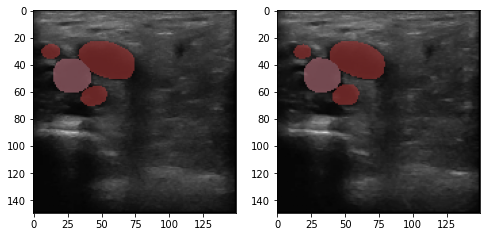

In [24]:
fig = plt.figure(figsize=(8,8))

plt.subplot(121)
plt.imshow(plots[0][0])
plt.subplot(122)
plt.imshow(plots[0][1])

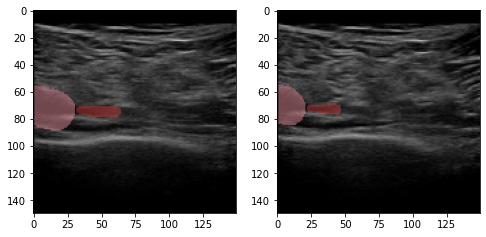

In [25]:
fig = plt.figure(figsize=(8,8))

plt.subplot(121)
plt.imshow(plots[1][0])
plt.subplot(122)
plt.imshow(plots[1][1])

In [ ]:
fig = plt.figure(figsize=(8,8))

plt.subplot(121)
plt.imshow(plots[2][0])
plt.subplot(122)
plt.imshow(plots[2][1])

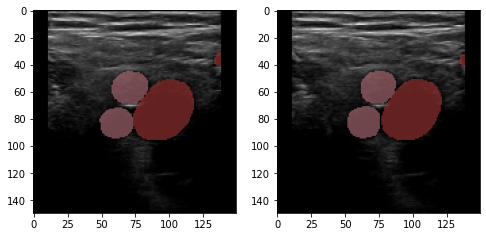

In [27]:
fig = plt.figure(figsize=(8,8))

plt.subplot(121)
plt.imshow(plots[3][0])
plt.subplot(122)
plt.imshow(plots[3][1])

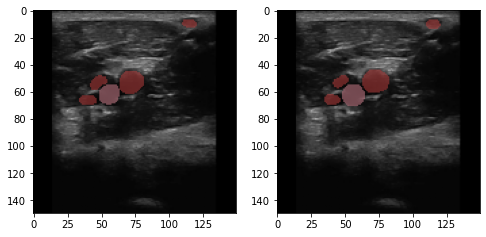

In [28]:
fig = plt.figure(figsize=(8,8))

plt.subplot(121)
plt.imshow(plots[4][0])
plt.subplot(122)
plt.imshow(plots[4][1])

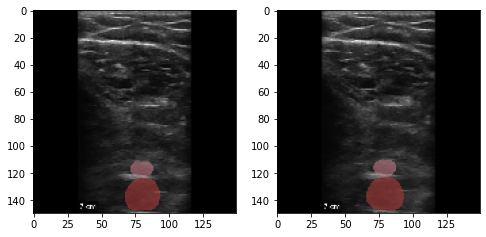

In [29]:
fig = plt.figure(figsize=(8,8))

plt.subplot(121)
plt.imshow(plots[5][0])
plt.subplot(122)
plt.imshow(plots[5][1])

# Processing
Next step is to load all images and save them in a .pth file, to load them later. This will be done in the US_data_processing file

In [38]:
overview_available.to_csv("~/MasterThesis/available_US_probands.csv")

# Flow Estimation Tests for visualization. 
This part of the notebook includes some tests on how to vizualize the optical flow fields and what is the best way to warp segementations. 

Most of the tests failed :(

In [32]:
baseline = cv2.optflow.DualTVL1OpticalFlow_create()

In [33]:
np.array(img_1)[:,:,np.newaxis].shape

(150, 150, 1)

In [34]:
in1 = np.array(img_1)[:,:,np.newaxis].astype(np.float32) / 255
in2 = np.array(img_2)[:,:,np.newaxis].astype(np.float32) / 255
flow = baseline.calc(in1,in2,None)

In [35]:
flow.shape

(150, 150, 2)

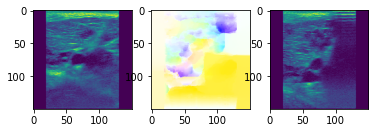

In [36]:
plt.subplot(131)
plt.imshow(in1)
plt.subplot(132)
plt.imshow(flow2img(flow))
plt.subplot(133)
plt.imshow(in2)

In [37]:
#flow = torch.from_numpy(flow)
seg = torch.from_numpy(np.asarray(seg_1)).long().contiguous() /200
seg.shape

torch.Size([150, 150])

In [38]:
flow=torch.from_numpy(flow)

In [39]:
warped = F.grid_sample(seg.unsqueeze(0).unsqueeze(0),flow.unsqueeze(0).reshape(1,150,150,2),mode='nearest',align_corners=False)
warped.shape

torch.Size([1, 1, 150, 150])

In [40]:
#warped_1 = warp(seg.unsqueeze(0).unsqueeze(0), flow.view(1,2,150,150))
warped_2 = warpImage(seg.view(1,1,150,150).float(), flow.view(1,2,150,150))

/home/nicke/miniconda3/envs/flowenv/lib/python3.8/site-packages/torch/nn/functional.py:4043: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/nicke/miniconda3/envs/flowenv/lib/python3.8/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [41]:
def overlaySegment(gray1,seg1,flag=False):
    H, W = seg1.squeeze().size()
    colors=torch.FloatTensor([0,0,0,199,67,66,225,140,154,78,129,170,45,170,170,240,110,38,111,163,91,235,175,86,202,255,52,162,0,183]).view(-1,3)/255.0
    segs1 = labelMatrixOneHot(seg1.unsqueeze(0),3)

    
    seg_color = torch.mm(segs1.view(3,-1).t(),colors[:3,:]).view(H,W,3)
    alpha = torch.clamp(1.0 - 0.5*(seg1>0).float(),0,1.0)

    overlay = (gray1*alpha).unsqueeze(2) + seg_color*(1.0-alpha).unsqueeze(2)
    if(flag):
        plt.imshow((overlay).numpy())
        plt.show()
    return overlay

def labelMatrixOneHot(segmentation, label_num):
    B, H, W = segmentation.size()
    values = segmentation.view(B,1,H,W).expand(B,label_num,H,W).to(segmentation.device)
    linspace = torch.linspace(0, label_num-1, label_num).long().view(1,label_num,1,1).expand(B,label_num,H,W).to(segmentation.device)
    matrix = (values.float()==linspace.float()).float().to(segmentation.device)
    for j in range(2,matrix.shape[1]):
        matrix[0,j,:,:] = matrix[0,j,:,:]
    return matrix

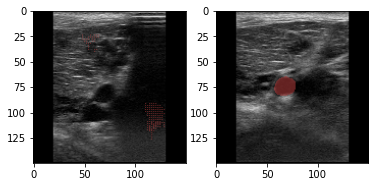

In [42]:
plt.subplot(121)
plt.imshow(overlaySegment(torch.from_numpy(in2).view(150,150),warped_2.view(150,150)))
plt.subplot(122)
plt.imshow(overlaySegment(torch.from_numpy(in1).view(150,150),seg.reshape(150,150)))

In [43]:
warped_2.shape

torch.Size([1, 1, 150, 150])

In [44]:
warped_2.max()

tensor(1.)

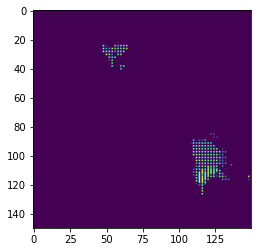

In [45]:
plt.imshow(warped_2.squeeze())

# Verdict baseline
has difficulties.. Probably need to look at the gird_sample or warp method to have best results.

In [47]:
flow = load_flownet2()

In [48]:
moving = F.interpolate(torch.from_numpy(in1).view(1,1,150,150), size=(2*64,2*64)).view(2*64,2*64,1) 
fixed = F.interpolate(torch.from_numpy(in2).view(1,1,150,150), size=(2*64,2*64)).view(2*64,2*64,1)

print(moving.shape)
print(fixed.shape)

image = preprocessing_flownet(fixed, moving)
image.shape

torch.Size([128, 128, 1])
torch.Size([128, 128, 1])


torch.Size([1, 3, 2, 128, 128])

In [49]:
flow_out = flow(image).squeeze().detach().numpy().transpose(1,2,0)
flow_out.shape

(128, 128, 2)

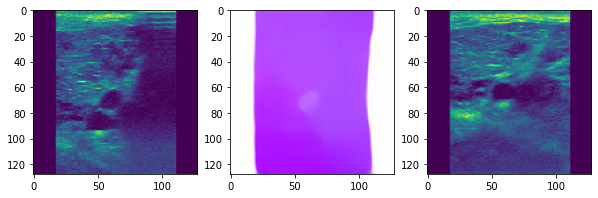

In [50]:
fig = plt.figure(figsize=(10,10))

plt.subplot(131)
plt.imshow(fixed)
plt.subplot(132)
plt.imshow(flow2img(flow_out))
plt.subplot(133)
plt.imshow(moving)

In [51]:
seg.shape

torch.Size([150, 150])

In [52]:
seg_inter = F.interpolate(seg.view(1,1,150,150), size=(128,128)).squeeze().long()
seg_inter.shape

torch.Size([128, 128])

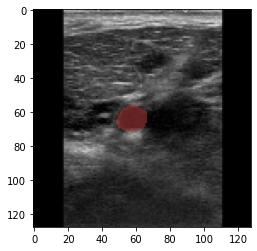

In [53]:
plt.imshow(overlaySegment(moving.squeeze(),seg_inter))

In [54]:
warped = warpImage(seg_inter.view(1,1,128,128).float(), torch.from_numpy(flow_out).reshape(1,2,128,128))
warped_sampled = F.grid_sample(seg_inter.view(1,1,128,128).float(), torch.from_numpy(flow_out).reshape(1,128,128,2))

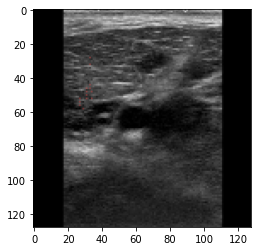

In [55]:
plt.imshow(overlaySegment(moving.view(128,128),warped.squeeze()))

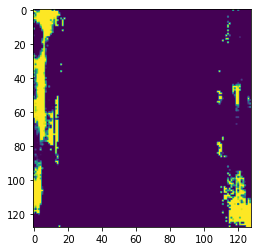

In [56]:
plt.imshow(warped_sampled.squeeze())

These two do not work so well.. Let's try the cuda sampling one

In [57]:
torch.cuda.is_available()

True

In [58]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [66]:
crnt_dev = torch.cuda.current_device()

warped = warp(seg_inter.view(1,1,128,128).float().to(crnt_dev), torch.from_numpy(flow_out).reshape(1,2,128,128).to(crnt_dev)).cpu()

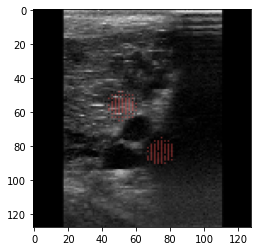

In [70]:
plt.imshow(overlaySegment(fixed.view(128,128),warped.squeeze()))

The does not look like it is good...
